# USING HUGGING FACES, LANGCHAIN, AND VECTOR DATABASES TO USE OUR OWN DOCUMENTS AS KNOWLEDGE DATABASE

In this notebook, we will use LangChain so that we can make queries to the language model that take into account our external information on which LLM model is not trained.

The information could be our own documents, or whatever was contained in a business knowledge database.

We can use different Kaggle Datasets and Language Models, so that it is easy to carry out different tests with different Datasets and Language Models (dolly-v2-3b or flan-t5-large).

The data has been loaded from a Pandas DataFrame, using the **DataFrameLoader** function from the **document_loaders** library of **LangChain**.

Keys:
* RAG
* Kaggle
* HuggingFace
* LangChain
* Embeddings
* LCEL


# Install and load the libraries.
To start we need to install the necesary Python packages.
* **[langchain](https://python.langchain.com/docs/get_started/introduction.html)**. The revolutionary framework to build apps using large language models.
* **[sentence_transformers](https://www.sbert.net/)**. necesary to create the embeddings we are going to store in the vector database.  
* **[chromadb](https://www.trychroma.com/)**. This is our vector Database. ChromaDB is easy to use and open source, maybe the most used Vector Database used to store embeddings.

In [1]:
!pip install -q chromadb==0.4.22
!pip install -q langchain==0.1.4
!pip install -q sentence_transformers==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 13.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/

# Load the Dataset

As we are working with limited computing resources in Kaggle, we limit the number of news to use with the variable MAX_NEWS.

The name of the field containing the text of the news is stored in the variable *DOCUMENT* and the metadata in *TOPIC*.

We are using kotartemiy/topic-labeled-news-dataset, but we can use following datasets:

https://www.kaggle.com/datasets/kotartemiy/topic-labeled-news-dataset

https://www.kaggle.com/datasets/gpreda/bbc-news

https://www.kaggle.com/datasets/deepanshudalal09/mit-ai-news-published-till-2023


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
news = pd.read_csv('/kaggle/input/topic-labeled-news-dataset/labelled_newscatcher_dataset.csv', sep=';')
MAX_NEWS = 1000
DOCUMENT="title"
TOPIC="topic"

#Because it is just a course we select a small portion of News.
subset_news = news.head(MAX_NEWS)

In [9]:
subset_news.head(2)

,topic,link,domain,published_date,title,lang
0,SCIENCE,https://www.eurekalert.org/pub_releases/2020-0...,eurekalert.org,2020-08-06 13:59:45,A closer look at water-splitting's solar fuel ...,en
1,SCIENCE,https://www.pulse.ng/news/world/an-irresistibl...,pulse.ng,2020-08-12 15:14:19,"An irresistible scent makes locusts swarm, stu...",en


# CREATE THE DOCUMENT FROM THE DATAFRAME
We are going to load the data from a pandas DataFrame. However, LangChain, through the **document_loader** library, supports multiple data sources, such as Word documents, Excel files, plain text, SQL, and more.

We also imported the Chroma library, which is used to save the embeddings in the ChromaDB database.

In [10]:
from langchain.document_loaders import DataFrameLoader
from langchain.vectorstores import Chroma


First, we create the loader, indicating the data source and the name of the column in the DataFrame where we store what we could consider as the document, that is, the information we want to pass to the model so that it takes it into account in its responses.

The name of the field containing the text of the news is stored in the variable *DOCUMENT* and the metadata in *TOPIC*.


In [11]:
df_loader = DataFrameLoader(subset_news, page_content_column=DOCUMENT)

Then, we use the loader to load the document.

In [13]:
df_document = df_loader.load()

In [14]:
display(df_document[:2])

[Document(page_content="A closer look at water-splitting's solar fuel potential", metadata={'topic': 'SCIENCE', 'link': 'https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php', 'domain': 'eurekalert.org', 'published_date': '2020-08-06 13:59:45', 'lang': 'en'}),
 Document(page_content='An irresistible scent makes locusts swarm, study finds', metadata={'topic': 'SCIENCE', 'link': 'https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw', 'domain': 'pulse.ng', 'published_date': '2020-08-12 15:14:19', 'lang': 'en'})]

# Creating the embeddings
First, we import a couple of libraries.
* CharacterTextSplitter: we will use it to group the information contained in different blocks.
* HuggingFaceEmbeddings: it will create the embeddings in the format that we will store in the database.

In [15]:
from langchain.text_splitter import CharacterTextSplitter
#from langchain.embeddings import HuggingFaceEmbeddings

We split the data into manageable chunks to store as vectors using **CharacterTextSplitter**. 

There isn't an exact way to do this, more chunks means more detailed context, but will increase the size of our vectorstore.  
There are no magic numbers to do this, but it is important to consider that the larger the chunk size, the more context the model will have, but the size of our vector store will also increase.

In [17]:
text_splitter = CharacterTextSplitter(chunk_size=250, chunk_overlap=10)
texts = text_splitter.split_documents(df_document)

In [18]:
display(texts[:2])

[Document(page_content="A closer look at water-splitting's solar fuel potential", metadata={'topic': 'SCIENCE', 'link': 'https://www.eurekalert.org/pub_releases/2020-08/dbnl-acl080620.php', 'domain': 'eurekalert.org', 'published_date': '2020-08-06 13:59:45', 'lang': 'en'}),
 Document(page_content='An irresistible scent makes locusts swarm, study finds', metadata={'topic': 'SCIENCE', 'link': 'https://www.pulse.ng/news/world/an-irresistible-scent-makes-locusts-swarm-study-finds/jy784jw', 'domain': 'pulse.ng', 'published_date': '2020-08-12 15:14:19', 'lang': 'en'})]

We load the library to create the pre trained model from HuggingFace to create the embeddings from sentences.


In [19]:
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Creating the Index With Chroma
Here we are creating the index of embeddings. Using the document, and the embedding function created above.

In [20]:
directory_cdb = '/kaggle/working/chromadb'
chroma_db = Chroma.from_documents(
    texts, embedding_function, persist_directory=directory_cdb
)

## LANGCHAIN

Now, we create our chain with LangChain. All we do is give it a retriever and a model to call with the result obtained from the retriever.

Now we are going to import RetrievalQA and HuggingFacePipeline classes from langchain module.  

In [21]:
from langchain.chains import RetrievalQA
from langchain.llms import HuggingFacePipeline
#from transformers import pipeline

Now we create the retriever object, the responsible to return the data contained in the ChromaDB Database.

In [22]:
retriever = chroma_db.as_retriever()

We can use two models from Fugging Face:

The first one is [dolly-v2-3b](https://huggingface.co/databricks/dolly-v2-3b), the smallest Dolly model. It have 3billion paramaters, more than enough for our sample, and works much better than GPT2. It's a text generation model, and therefore generates slightly more imaginative responses.

The second one is a t5 model. This is a text2text-generation. so it will produce more concise and succinct responses.


In [23]:
model_id = "databricks/dolly-v2-3b" #textgeneration model for testing
task="text-generation"

#model_id = "google/flan-t5-large" #Nice text2text model
#task="text2text-generation"

We use HuggingFacePipeline class to create a pipeline for a specific Hugging Face language model. Let's break down the code:

* **model_id**: This is the ID of the Hugging Face language model you want to use. It typically consists of the model name and version.
* **task**: This parameter specifies the task that you want to perform using the language model. It could be "text-generation", "text2text-generation", "question-answering", or other tasks supported by the model.
* **model_kwargs**: Allows you to provide additional arguments specific to the chosen model. In this case, it sets "temperature" to 0 (indicating deterministic output) and "max_length" to 256, which limits the maximum length of generated text to 256 tokens.
* **pipeline_kwargs**: Allows you to provide extra information related to the pipeline.


In [24]:
#If you want to test the  T5 model remove the return_full_text parameter in pipeline_kwargs,
# databricks/dolly-v2-3b model 
hf_llm = HuggingFacePipeline.from_model_id(
    model_id=model_id,
    task=task,
    pipeline_kwargs={
        "max_new_tokens": 256,
        "repetition_penalty":1.1,
        "return_full_text":True
    },
)

#If you want to test the  T5 model remove the return_full_text parameter in pipeline_kwargs,
#also I recommend to add model_kwargs and change the temperature.
#    model_kwargs={
#        "temperature": 0,
#        "max_length": 256
#    },

tokenizer_config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.68G [00:00<?, ?B/s]

We are setting up the ***document_qa***, a **RetrievalQA** object, that we are going to use to run the questions.

The ***stuff*** type is the simplest type of chain that we can have. I get the documents from the retiever and use the language model to obtain responses.

In [25]:
document_qa = RetrievalQA.from_chain_type(
    llm=hf_llm, retriever=retriever, chain_type='stuff'
)

In [26]:
#Sample question for newscatcher dataset.
response = document_qa.invoke("Can I buy a Toshiba laptop?")

#Sample question for BBC Dataset.
#response = document_qa.run("Who is going to meet boris johnson?")
display(response)

{'query': 'Can I buy a Toshiba laptop?',
 'result': ' No, Toshiba officially stopped making laptops in April 2023.\n\n'}

### Using the new LCEL Architecture from LangChain.
LangChain recommends using LCEL (LangChain Expression Language) over Chains, as LCEL is better and recommended approach.

In [27]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

template = """Answer the question based on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

In [28]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | hf_llm
    | StrOutputParser()
)

In [29]:
chain.invoke("Can I buy a Toshiba laptop?")

'Answer: No, Toshiba officially ended its laptop manufacturing operations in 2023.\n\n'

## Checking relevant information based on the cosine distance between sentences.

Vector databases find the most relevant information to a user's question by measuring the distance between embeddings.


In [30]:
embedding_s1 = embedding_function.embed_query(
    "I would like to eat more vegetables and exercise every day")

embedding_s2 = embedding_function.embed_query(
    "I will try to maintain a healthier lifestyle.")

embedding_s3 = embedding_function.embed_query(
    "I prefer to play football")



In [33]:
# All the embeddings have the same lenght despite the sentence length.
print(f""" embedding_s1 = {len(embedding_s1)}
 embedding_s2 =  {len(embedding_s2)}
 embedding_s3 =  {len(embedding_s3)}""")

 embedding_s1 = 384
 embedding_s2 =  384
 embedding_s3 =  384


In [34]:
# 5 first positions of embedding_s1.
print(embedding_s1[:5])
print(embedding_s2[:5])
print(embedding_s3[:5])

[-0.03452673181891441, 0.03168030083179474, -0.03841092437505722, 0.07523445039987564, -0.04117882251739502]
[-0.009032459929585457, 0.014947176910936832, 0.06308789551258087, 0.06641356647014618, 0.03385468199849129]
[0.01728086546063423, -0.019022805616259575, 0.011131885461509228, -0.0038361945189535618, 0.03133483976125717]


Importing SKLEARN to measure the cosine distances

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
embedding_s1_2d = np.array(embedding_s1).reshape(1, -1)
embedding_s2_2d = np.array(embedding_s2).reshape(1, -1)
embedding_s3_2d = np.array(embedding_s3).reshape(1, -1)

In [37]:
print(embedding_s1_2d[0][:5])

[-0.03452673  0.0316803  -0.03841092  0.07523445 -0.04117882]


S1 sentence is more similar to S2 sentence than to S3 sentence. That is because the first sentences are talking about a healthier way of live.

In [38]:
print(cosine_similarity(embedding_s1_2d, embedding_s2_2d))
print(cosine_similarity(embedding_s1_2d, embedding_s3_2d))
print(cosine_similarity(embedding_s2_2d, embedding_s3_2d))


[[0.54180286]]
[[0.16314692]]
[[0.25131373]]


## Print embeddings

In [39]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform PCA for 2D visualization
PCA_model = PCA(n_components = 2)

In [40]:
embeddings_sentences=[]
embeddings_sentences.append(embedding_s1)
embeddings_sentences.append(embedding_s2)
embeddings_sentences.append(embedding_s3)
PCA_model.fit(embeddings_sentences)
embeddings_coord = PCA_model.transform(embeddings_sentences)

In [41]:
print(embeddings_coord)

[[-0.46251846 -0.44190479]
 [-0.31148548  0.50339059]
 [ 0.77400394 -0.06148581]]


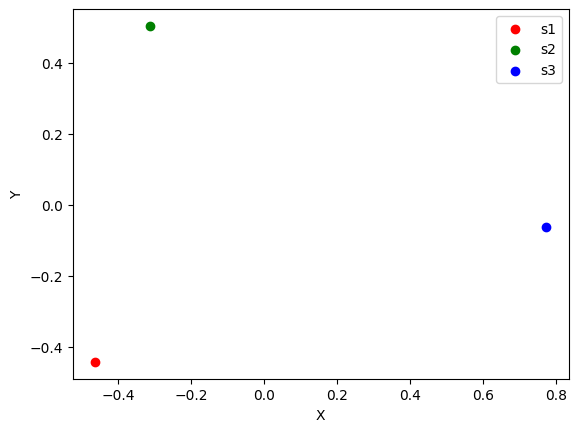

In [42]:
import matplotlib.pyplot as plt

x, y = zip(*embeddings_coord)

# Name the points
names = ['s1', 's2', 's3']
# Colors
colors = ['red', 'green', 'blue']

for i, name in enumerate(names):
    plt.scatter(x[i], y[i], marker='o', color=colors[i], label=name)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


# Conclusions.

We have used a vectorial database to store the information from a Kaggle dataset. We have incorporated it into a LangChain chain through a retriever, and now we are able to make queries about the information contained in the dataset to a some Hugging Face Language Models.
